# Classifying Music Genre From Audio
### *Deep Learning Final Project*

**By Ofir Lachmi**


### Exploratory Data Analysis

sample_rate=22050
waveform.shape=torch.Size([1, 661794])


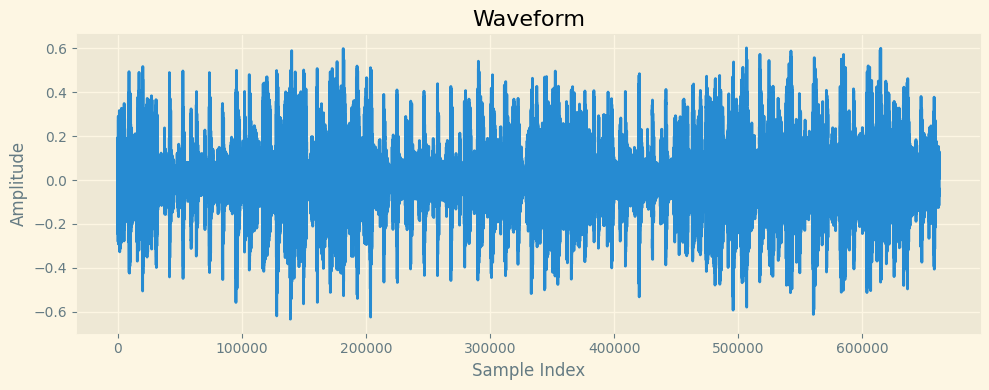

In [20]:
import torchaudio
import matplotlib.pyplot as plt
from matplotlib import style
from IPython.display import Audio


SAMPLE_FILE = "./GTZAN/Data/genres_original/reggae/reggae.00000.wav"

waveform, sample_rate = torchaudio.load(SAMPLE_FILE)

print(f"{sample_rate=}")
print(f"{waveform.shape=}")

display(Audio(waveform, rate=sample_rate, normalize=True))

style.use("Solarize_Light2")
plt.figure(figsize=(10, 4))
plt.plot(waveform[0])
plt.title("Waveform")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.grid(True)
plt.tight_layout()
plt.show()

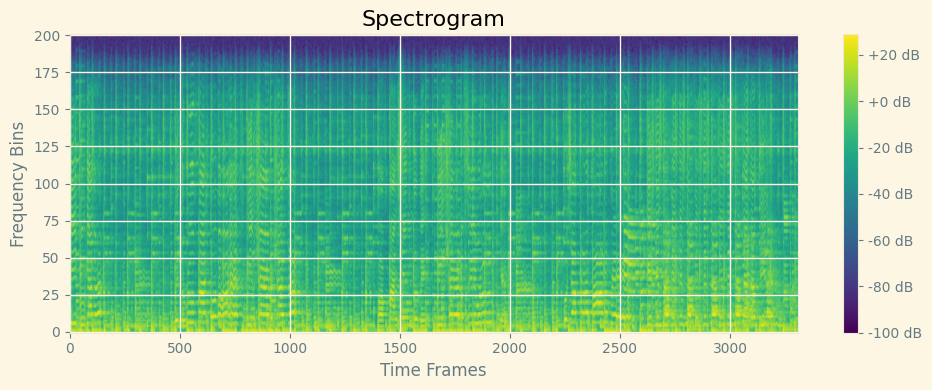

In [21]:
import torchaudio.transforms as T

spectrogram = T.Spectrogram()(waveform)
spectrogram = T.AmplitudeToDB()(spectrogram)

plt.figure(figsize=(10, 4))
plt.imshow(spectrogram[0], aspect="auto", origin="lower", cmap="viridis")
plt.title("Spectrogram")
plt.xlabel("Time Frames")
plt.ylabel("Frequency Bins")
plt.colorbar(format="%+2.0f dB")
plt.tight_layout()
plt.show()

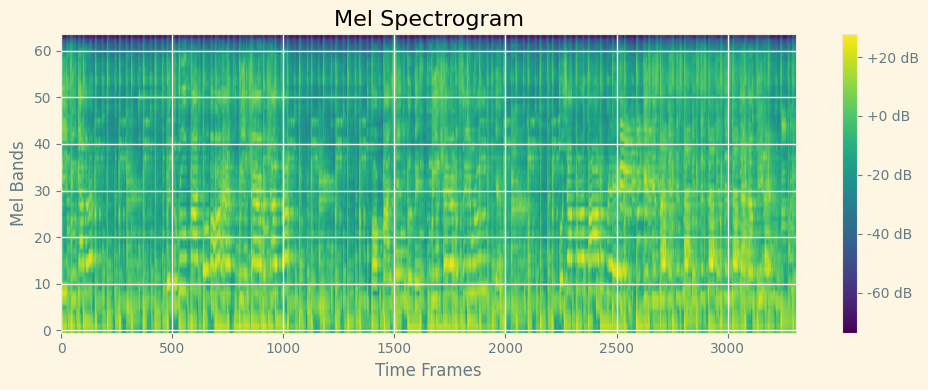

In [22]:
mel_spectrogram = T.MelSpectrogram(sample_rate, n_mels=64)(waveform)
mel_spectrogram = T.AmplitudeToDB()(mel_spectrogram)

plt.figure(figsize=(10, 4))
plt.imshow(mel_spectrogram[0], aspect="auto", origin="lower", cmap="viridis")
plt.title("Mel Spectrogram")
plt.xlabel("Time Frames")
plt.ylabel("Mel Bands")
plt.colorbar(format="%+2.0f dB")
plt.tight_layout()
plt.show()

### Preparing the data

In [8]:
import pickle
import os
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import numpy as np

REBUILD_DATA = False


class MusicGenres(Dataset):
    GENRES = [
        "blues",
        "classical",
        "country",
        "disco",
        "hiphop",
        "jazz",
        "metal",
        "pop",
        "reggae",
        "rock",
    ]
    LABELS = {g: i for i, g in enumerate(GENRES)}
    BASE_DIR = "./GTZAN/Data/genres_original"
    SAMPLE_RATE = 16000
    TIME_FRAMES = 256

    raw_data = []

    def __init__(self):
        if REBUILD_DATA:
            self.make_training_data()
            self.save()
        self.load()

    def __getitem__(self, index):
        return self.raw_data[index]

    def __len__(self):
        return len(self.raw_data)

    def save(self):
        with open("training_data.pkl", "wb") as outfile:
            pickle.dump(self.raw_data, outfile)

    def load(self):
        with open("training_data.pkl", "rb") as infile:
            self.raw_data = pickle.load(infile)

    def make_training_data(self):
        for genre in tqdm(self.LABELS):
            dirpath = os.path.join(self.BASE_DIR, genre)
            y = np.eye(len(self.GENRES), dtype=np.float32)[
                self.LABELS[genre]
            ]  # one-hot array
            for f in tqdm(os.listdir(dirpath), leave=False):
                try:
                    filepath = os.path.join(dirpath, f)
                    waveform, sample_rate = torchaudio.load(filepath)

                    # consistant sample rate
                    waveform = T.Resample(sample_rate, self.SAMPLE_RATE)(waveform)

                    # convert to mono
                    if waveform.shape[0] > 1:
                        waveform = torch.mean(waveform, dim=0, keepdim=True)

                    mel_spectrogram = T.MelSpectrogram(sample_rate, n_mels=64)(waveform)
                    mel_spectrogram = T.AmplitudeToDB()(mel_spectrogram)
                    mel_spectrogram /= 80.0

                    _, _, total_frames = mel_spectrogram.shape
                    mel_spectrogram = mel_spectrogram[
                        :, :, : -1 * (total_frames % self.TIME_FRAMES)
                    ]

                    num_chunks = total_frames // self.TIME_FRAMES
                    data_chunks = np.split(mel_spectrogram, num_chunks, axis=2)
                    data_chunks = [(data, y) for data in data_chunks]

                    self.raw_data.extend(data_chunks)

                except Exception as e:
                    print(f, e)
                    pass

        np.random.shuffle(self.raw_data)


dataset = MusicGenres()

TEST_PCT = 0.1
BATCH_SIZE = 64

training_data, test_data = torch.utils.data.random_split(
    dataset, [1 - TEST_PCT, TEST_PCT]
)
train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)


### Making the model

In [14]:
from torch import nn
import torch.nn.functional as F

# TODO: torch summary


class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(64, 128, 5)
        self.pool3 = nn.MaxPool2d(2)

        # use dummy data to find the input size for the linear layer
        x = torch.randn(64, 256).view(-1, 1, 64, 256)
        self._to_linear = None
        self.convs(x)

        self.fc1 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(512, 10)

    def convs(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)

        if self._to_linear is None:
            self._to_linear = x.shape[1] * x.shape[2] * x.shape[3]
            print(f"{self._to_linear=}")

        return x

    def forward(self, x):
        x = self.convs(x)

        x = x.view(-1, self._to_linear)

        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)


MODEL_NAME = "cnn-3l"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net = CNN().to(device)


self._to_linear=14336


### Training

In [48]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr=0.0001)
loss_function = nn.MSELoss()


def train_one_epoch():
    correct = 0
    total = 0
    for X, y in train_dataloader:
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()

        net_out = net(X)
        loss = loss_function(net_out, y)

        loss.backward()
        optimizer.step()

        real_class = torch.argmax(y, dim=1)
        predicted = torch.argmax(net_out, dim=1)
        correct += (real_class == predicted).sum().item()
        total += y.shape[0]

    accuracy = correct / total
    return loss.item(), accuracy


def test():
    correct = 0
    total = 0
    with torch.no_grad():
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)

            net_out = net(X)
            loss = loss_function(net_out, y)

            real_class = torch.argmax(y, dim=1)
            predicted = torch.argmax(net_out, dim=1)
            correct += (real_class == predicted).sum().item()
            total += y.shape[0]

    accuracy = correct / total
    return loss.item(), accuracy

In [49]:
import time

EPOCHS = 30

with open("model.log", "a") as f:
    for epoch in tqdm(range(EPOCHS)):
        train_loss, train_acc = train_one_epoch()
        test_loss, test_acc = test()
        f.write(
            f"{MODEL_NAME}, {round(time.time(), 2)}, {round(train_loss, 4)}, {round(train_acc, 4)}, {round(test_loss, 4)}, {round(test_acc, 4)}\n"
        )
        # print(f"{train_loss=}, {train_acc=}\n{test_loss=}, {test_acc=}\n")

100%|██████████| 30/30 [06:11<00:00, 12.38s/it]


In [23]:
test_loss, test_acc = test()
print(f"Accuracy: {test_acc * 100:.3f}%")

Accuracy: 68.743%


In [1]:
import pandas as pd


def create_acc_loss_graph(model_name):
    df = pd.read_csv(
        "model.log",
        names=[
            "model_name",
            "time",
            "train_loss",
            "train_acc",
            "test_loss",
            "test_acc",
        ],
    )
    df = df[df["model_name"] == model_name]

    x = df.index

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))  # Adjust size as needed

    ax1.plot(x, df["train_loss"], label="Train Loss")
    ax1.plot(x, df["test_loss"], label="Test Loss")
    ax1.set_title("Train Loss vs Test Loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.legend()
    ax1.grid(True)

    ax2.plot(x, df["train_acc"], label="Train Accuracy")
    ax2.plot(x, df["test_acc"], label="Test Accuracy")
    ax2.set_title("Train Accuracy vs Test Accuracy")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Loss")
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()


create_acc_loss_graph("cnn-3l")

NameError: name 'plt' is not defined